In [3]:
import IPython
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sympy
import datetime

# для расчетов над tdb
# from pycalphad import Database, equilibrium, variables as v, binplot

# для MCMC расчетов
import pymc as pm  # пакет для MCMC расчетов 
import arviz as az # пакет для работы с типом данных arviz
import pytensor
import pytensor.tensor as pt
# import theano
# theano.config.exception_verbosity = 'high' # должно выдавать подробное описание ошибки, но не помогает

import aesara

import seaborn as sns

# пути к tdb
db_path = 'tdbs/CoCr-01Oik_with_new_functions.tdb'

print(f"Running on PyMC v{pm.__version__}") # 5.3.1 or 5.1.2
print(f"Running on NumPy v{np.__version__}") # 1.22.1
print(f"Running on ArviZ v{az.__version__}") # 0.12.1

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (aesara.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (aesara.configdefaults): g++ not detected!  Aesara will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set Aesara flags cxx to an empty string.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Running on PyMC v5.3.1
Running on NumPy v1.22.1
Running on ArviZ v0.15.1


In [4]:
trace = az.from_json('calc_res/20230505_trace_cocr10_700x1000x4.json')
ppc = az.from_json('calc_res/20230505_ppc_cocr10_700x1000x4.json')
pp = az.from_json('calc_res/20230505_pp_cocr10_1000.json')
main = trace.extend(ppc)
par_list = ['SIGMA_OLD_COCRCO_0', 'SIGMA_OLD_COCRCO_1', 'SIGMA_OLD_COCRCR_0', 'SIGMA_OLD_COCRCR_1']

array([[<Axes: title={'center': 'SIGMA_OLD_COCRCO_0'}>,
        <Axes: title={'center': 'SIGMA_OLD_COCRCO_0'}>],
       [<Axes: title={'center': 'SIGMA_OLD_COCRCO_1'}>,
        <Axes: title={'center': 'SIGMA_OLD_COCRCO_1'}>],
       [<Axes: title={'center': 'SIGMA_OLD_COCRCR_0'}>,
        <Axes: title={'center': 'SIGMA_OLD_COCRCR_0'}>],
       [<Axes: title={'center': 'SIGMA_OLD_COCRCR_1'}>,
        <Axes: title={'center': 'SIGMA_OLD_COCRCR_1'}>]], dtype=object)

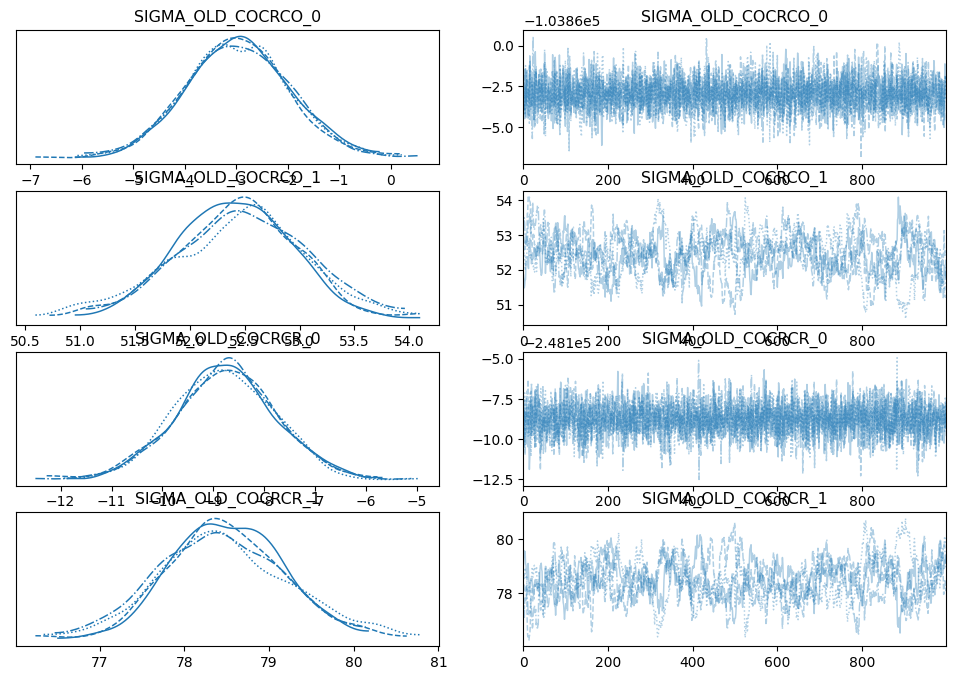

In [5]:
az.plot_trace(trace)

In [6]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
SIGMA_OLD_COCRCO_0,-103862.968,1.001,-103864.757,-103861.024,0.017,0.012,3616.0,3018.0,1.00
SIGMA_OLD_COCRCO_1,52.435,0.571,51.395,53.563,0.046,0.033,155.0,322.0,1.01
SIGMA_OLD_COCRCR_0,-248108.762,0.982,-248110.513,-248106.846,0.016,0.011,3642.0,2848.0,1.00
SIGMA_OLD_COCRCR_1,78.475,0.719,77.098,79.834,0.058,0.041,152.0,281.0,1.01


**r_hat** - статистика Гельмана-Рубина, значение близкое к 1 говорит о том, что вероятнее всего (не гарантировано) цепи сходятся.

<Axes: xlabel='y_norm / y_norm'>

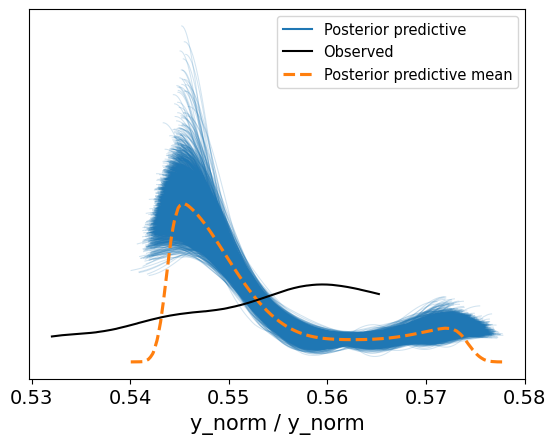

In [7]:
az.plot_ppc(ppc)

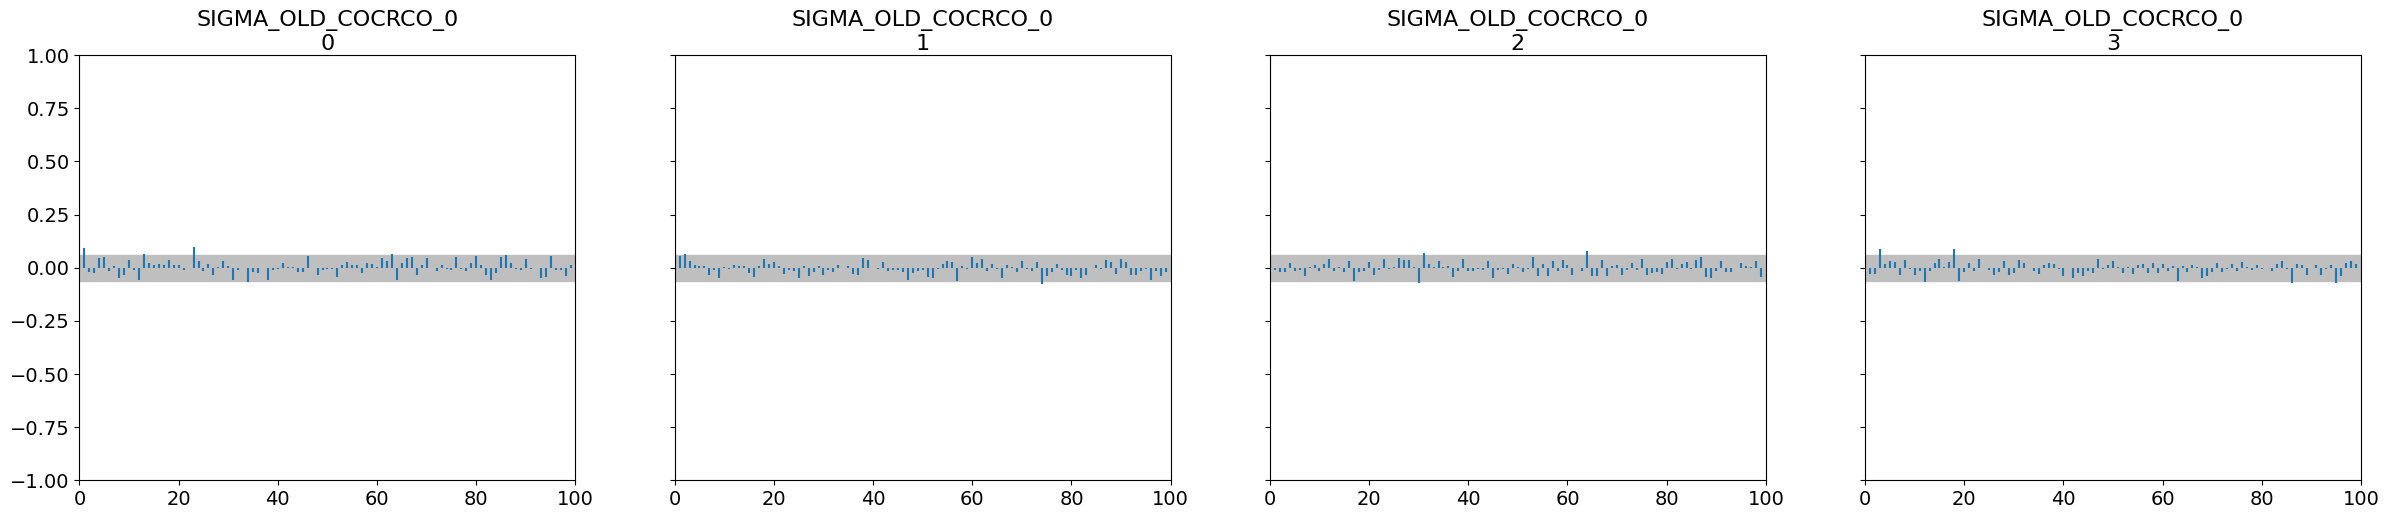

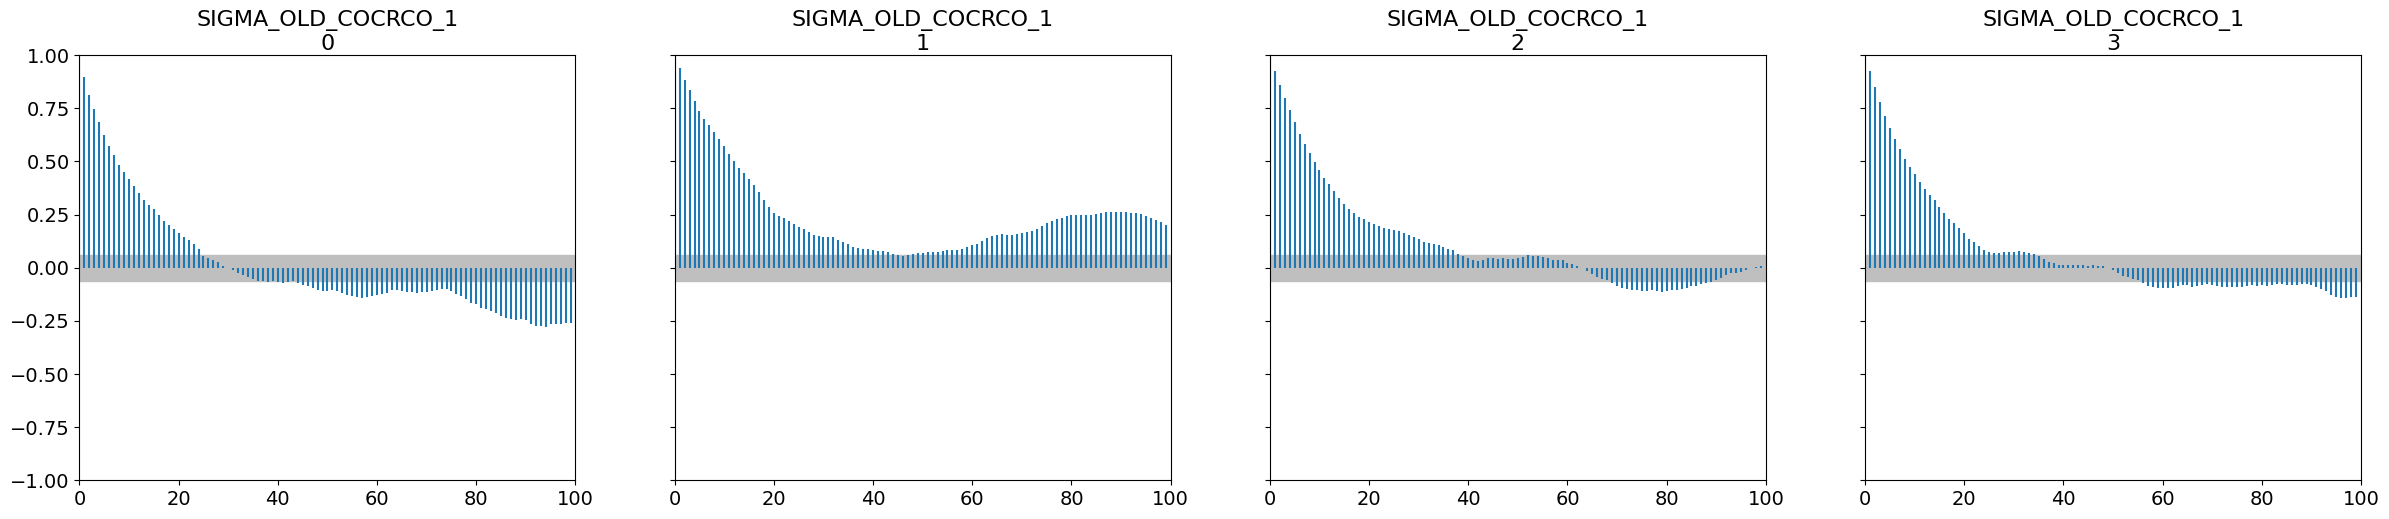

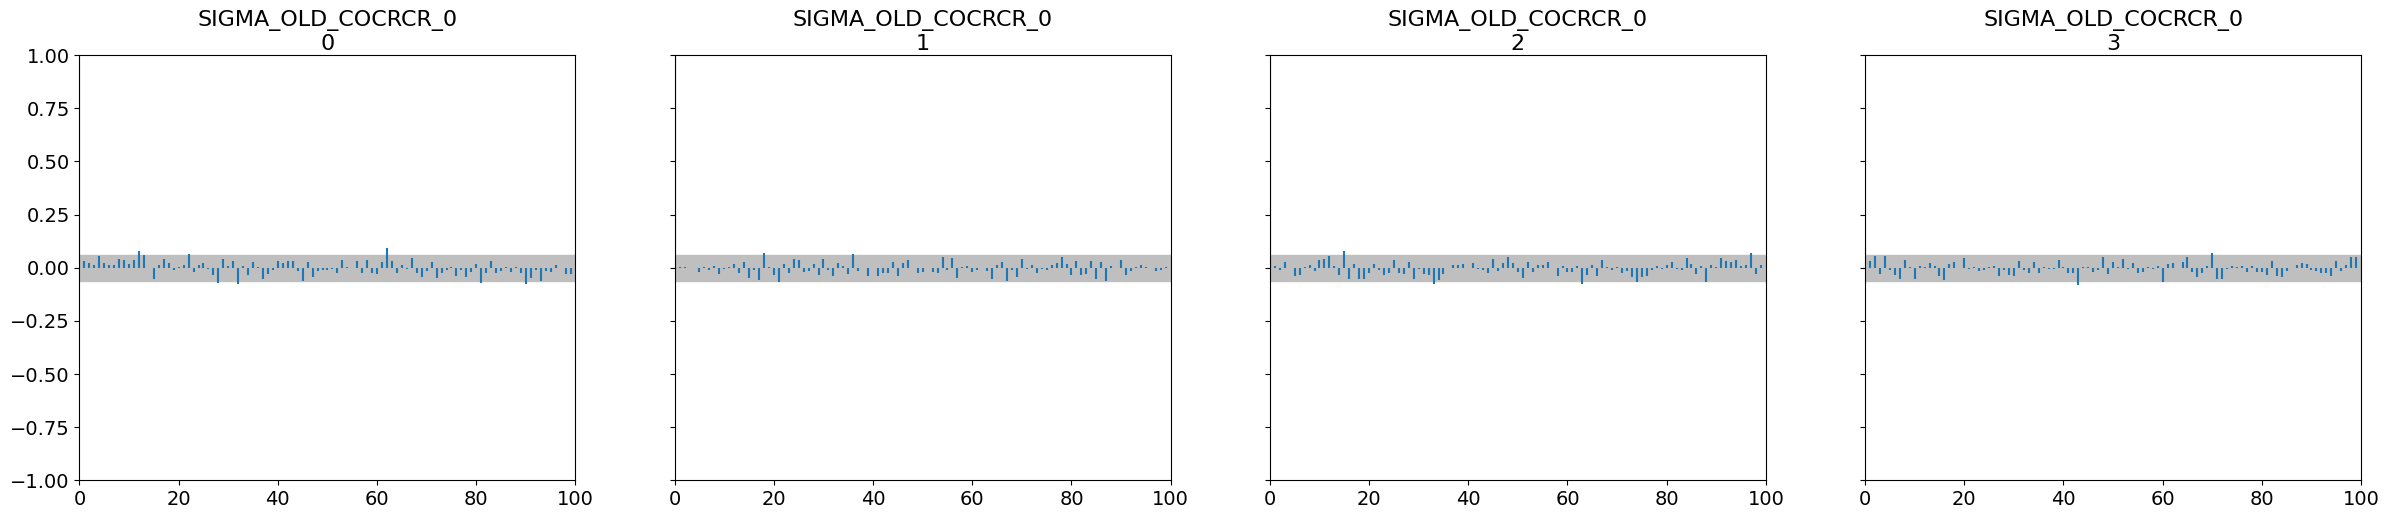

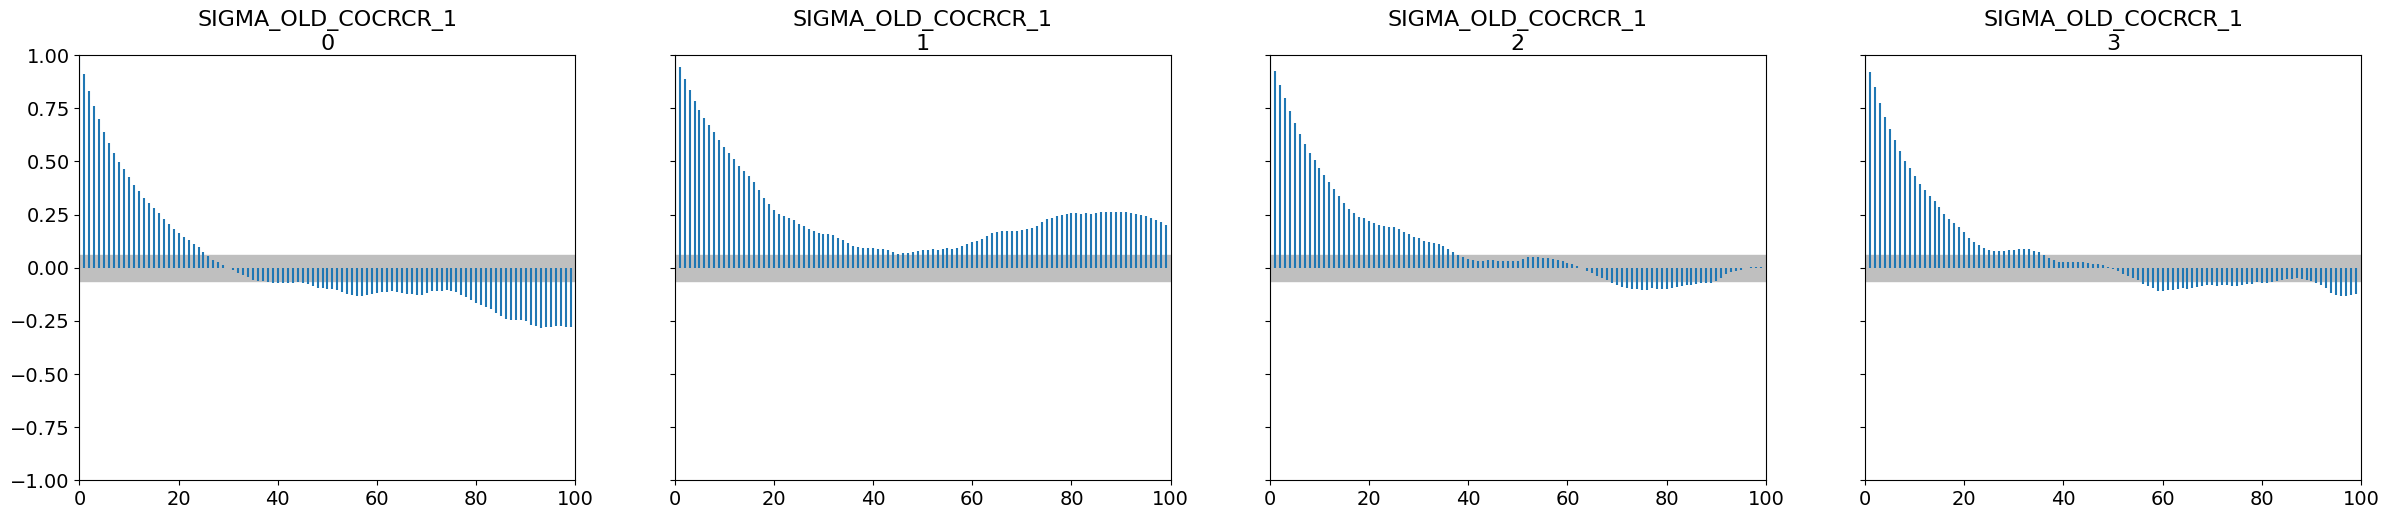

In [8]:
for par in par_list:
    az.plot_autocorr(trace, var_names = par)

Правдоподобие модели

In [11]:
trace.log_likelihood.mean()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    y_norm   float64 -84.7

WAIC

In [19]:
az.waic(trace)

c:\Users\emgebrishvili\AppData\Local\Programs\Python\Python310\lib\site-packages\arviz\stats\stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 4000 posterior samples and 13 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -1219.62   422.07
p_waic      202.05        -

There has been a warning during the calculation. Please check the results.

Апостериорная вероятность модели

In [21]:
# az.plot_density(trace)

array([<Axes: title={'center': 'SIGMA_OLD_COCRCO_0'}>,
       <Axes: title={'center': 'SIGMA_OLD_COCRCO_1'}>,
       <Axes: title={'center': 'SIGMA_OLD_COCRCR_0'}>,
       <Axes: title={'center': 'SIGMA_OLD_COCRCR_1'}>], dtype=object)

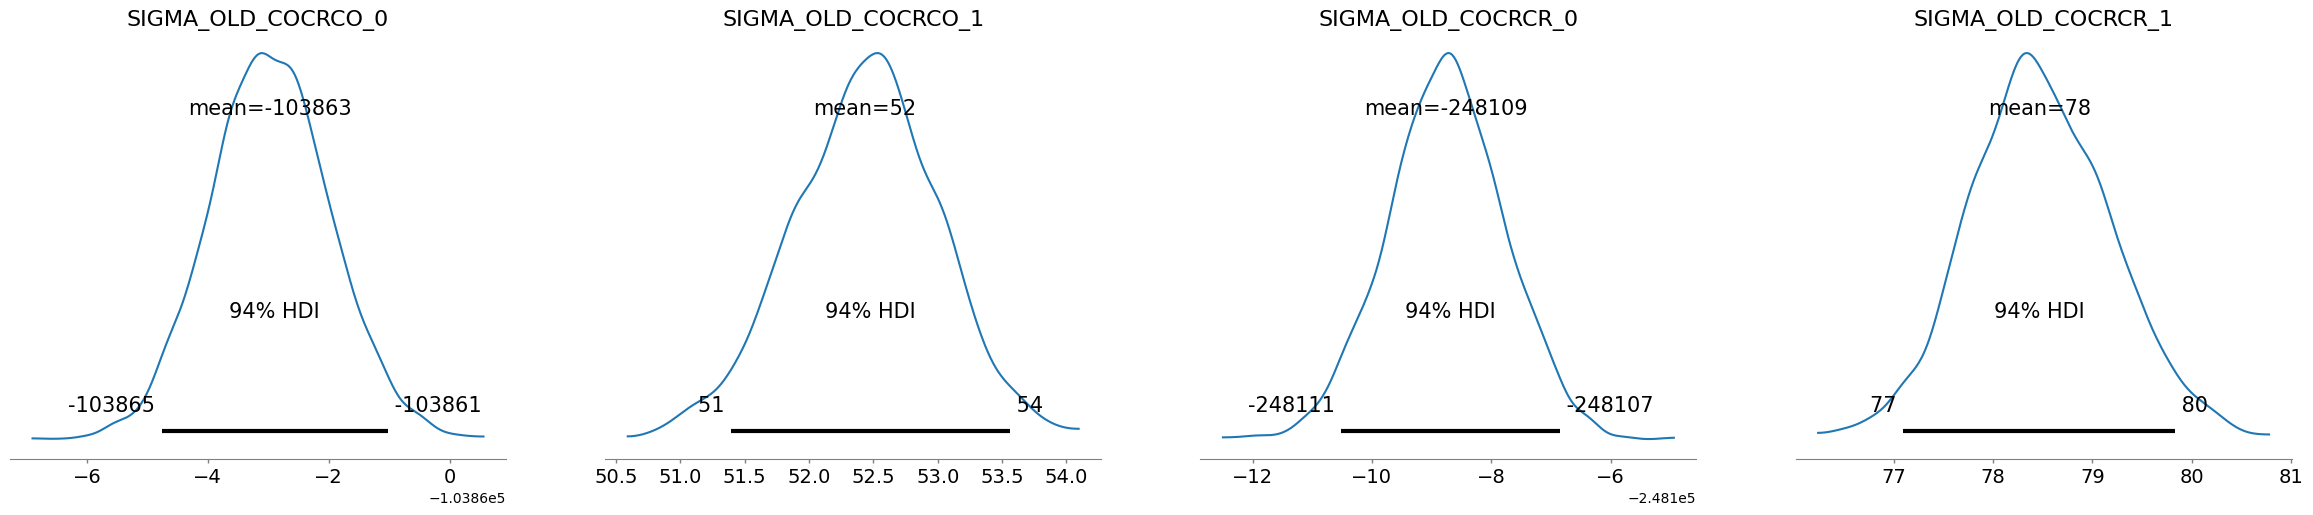

In [20]:
az.plot_posterior(trace)

In [25]:
from pycalphad import Database
db = Database(db_path)

In [36]:
full_par_dict = db.symbols
par_dict = dict()

for par in par_list:
    par_dict[par] = np.float32(full_par_dict[par].args_as_sympy()[0])
par_dict

{'SIGMA_OLD_COCRCO_0': -103863.0,
 'SIGMA_OLD_COCRCO_1': 47.47,
 'SIGMA_OLD_COCRCR_0': -248108.8,
 'SIGMA_OLD_COCRCR_1': 79.12}

In [55]:
# объединяем все цепи для каждого параметра
par_chains_dict = dict()
for par in par_list:
    par_chains_dict[par] = np.float32(np.concatenate(trace.posterior.variables[par]))

In [88]:
# вычисляем объем каждого сэмпла
chains_num = trace.sample_stats.chain.data.shape
draws_num = trace.sample_stats.draw.data.shape
num_points = chains_num[0]*draws_num[0]

In [94]:
''' 
считаем апостериорную вероятность параметров модели:
    1. вычисляем количество вхождений фактического значения параметра модели (округлив до 1 знака) в распределение параметра
    2. делим число на размер сэмплов
    3. перемножаем логарифмы = получаем апостериорную вероятность
'''
odds_dict = dict()
model_post_odd = 1
for par in par_list:
    odds_dict[par] = np.count_nonzero(np.round(par_chains_dict[par], 0) == np.round((par_dict[par]), 0))/num_points
    model_post_odd *= np.log(odds_dict[par])

In [95]:
odds_dict

{'SIGMA_OLD_COCRCO_0': 0.3815,
 'SIGMA_OLD_COCRCO_1': 0.0,
 'SIGMA_OLD_COCRCR_0': 0.38625,
 'SIGMA_OLD_COCRCR_1': 0.38725}

In [93]:
model_post_odd

inf